# Analyse BlueSeis BSPF Events

In [2]:
import os
import obspy as obs
import numpy as np
import matplotlib.pyplot as plt

from sixdegrees import sixdegrees

## Configurations

Set configuration parameters for the event and data

In [1]:
config = {
    # Required time window parameters
    'tbeg': "2025-04-14 17:08:35",  # Start time
    'tend': "2025-04-14 17:09:10",  # End time
    
    # event
    'origin_time': "2025-04-14 17:08:28",
    'magnitude': 5.2,
    
    # Station coordinates (required)
    'station_lon': -116.455439,  # BSPF longitude
    'station_lat': 33.610643,    # BSPF latitude
    
    # SEED identifiers
    'seed': "XX.BSPF..",     # Default seed ID
    'rot_seed': ["PY.BSPF..HJZ", "PY.BSPF..HJN", "PY.BSPF..HJE"],  # Rotation sensor seed ID
    'tra_seed': ["PY.PFOIX..HHZ", "PY.PFOIX..HHN", "PY.PFOIX..HHE"],  # Translation sensor seed ID
    
    # data source
    'data_source': "fdsn",
    'fdsn_client_rot': "IRIS",
    'fdsn_client_tra': "IRIS",

    # Path configurations
    'workdir': "./",            # Working directory
    'path_to_data_out': "./output/",  # Output directory

    # Project information
    'project': "BSPF_Analysis",  # Project name
    
    # rotate to ZNE
    'rotate_zne': True,

    # Backazimuth calculation parameters
    'baz_step': 1,              # Step size for backazimuth search in degrees
    'twin_sec': 1,              # Window length in seconds
    'twin_overlap': 0.5,        # Window overlap in percent
    
    # Optional parameters
    'verbose': True,            # Print detailed information
}

Initalize a sixdegrees object

In [3]:
sd = sixdegrees(conf=config)

Store the configuration as a pickle file

In [4]:
sd.store_as_pickle(config, "./event_configs/"+f"M{str(config['magnitude']).replace('.','')}_{config['tbeg'][:10].replace('-','')}")

 -> stored: ./event_configs/M52_20250414.pkl


Get key information about the event

In [5]:
ev = sd.get_event_info(origin_time=config['origin_time'],
                       base_catalog="USGS",
                       magnitude=config['magnitude'])

Found event:
Origin time: 2025-04-14T17:08:28.110000Z
Magnitude: 5.21 mw
Location: 33.036°N, -116.595°E
Depth: 14.3 km
Epicentral Distance: 65.1 km
Epicentral Distance: 0.6°
Backazimuth: 191.5°


This will load the data from the specified data source:
- local mseed file
- local sds system
- fdsn (online)


In [7]:
sd.load_data(config['tbeg'], config['tend'])

-> fetching PY.PFOIX..HHZ data from FDSN
-> fetching PY.PFOIX..HHN data from FDSN
-> fetching PY.PFOIX..HHE data from FDSN
-> successfully removed response
-> rotating translational data to ZNE
3 Trace(s) in Stream:
PY.PFOIX..HHZ | 2025-04-14T17:08:34.000000Z - 2025-04-14T17:09:11.000000Z | 200.0 Hz, 7401 samples
PY.PFOIX..HHN | 2025-04-14T17:08:34.000000Z - 2025-04-14T17:09:11.000000Z | 200.0 Hz, 7401 samples
PY.PFOIX..HHE | 2025-04-14T17:08:34.000000Z - 2025-04-14T17:09:11.000000Z | 200.0 Hz, 7401 samples
-> fetching PY.BSPF..HJZ data from FDSN
-> fetching PY.BSPF..HJN data from FDSN
-> fetching PY.BSPF..HJE data from FDSN
-> successfully removed sensitivity
-> rotating rotational data to ZNE
3 Trace(s) in Stream:
PY.BSPF..HJZ | 2025-04-14T17:08:34.003700Z - 2025-04-14T17:09:10.998700Z | 200.0 Hz, 7400 samples
PY.BSPF..HJN | 2025-04-14T17:08:34.003700Z - 2025-04-14T17:09:10.998700Z | 200.0 Hz, 7400 samples
PY.BSPF..HJE | 2025-04-14T17:08:34.003700Z - 2025-04-14T17:09:10.998700Z | 200

Ensure that all traces of stream have the same sample size

In [8]:
sd.trim_stream(set_common=True, set_interpolate=False)

 -> stream size inconsistent: [7401, 7401, 7401, 7400, 7400, 7400]
  -> adjusted: [7400, 7400, 7400, 7400, 7400, 7400]


Now we can have a look at the waveforms of all 6 components

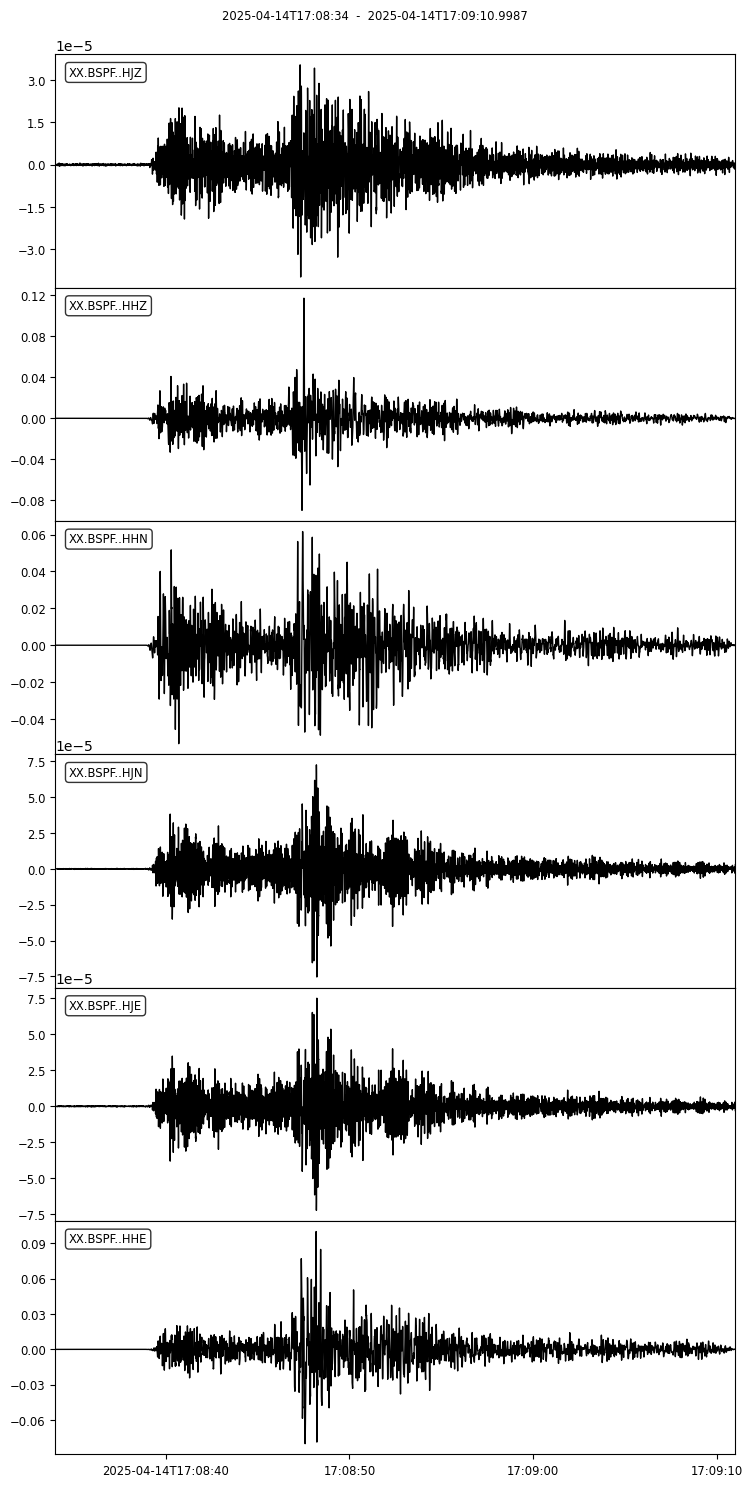

In [9]:
sd.st.plot(equal_scale=False);

### Only required for time lag correction

This computes the time lag between the translation and rotation components based on cross-correlation for transverse and vertical component combinations. If correction is True, the time lag is applied to the rotation component.

In [10]:
#find (and correct) time lag between translation and rotation data
# sd.get_component_lag(normalize=True,
#                      baz=ev['backazimuth'],
#                      correct=True)

# update endtime
# sd.tend = sd.tbeg+25

# trim stream
# sd.st = sd.st.trim(sd.tbeg, sd.tend)

# sd.st.plot(equal_scale=False);

### Write data to file or SDS system

This allows to write the data to a file or the SDS system. For the mseed file the seed id is as specified in the config.

In [11]:
# write to mseed file
# sd.st.write(f"./data/eventM{round(ev['magnitude'], 1)}_6c.mseed", format="MSEED")

# write to sds filesystem
# sd.write_to_sds(sd.st, "./data/", format="MSEED")

## Analysis

### Wavelet Comparsion

This allows to compute the CWT for all components and plot the results.

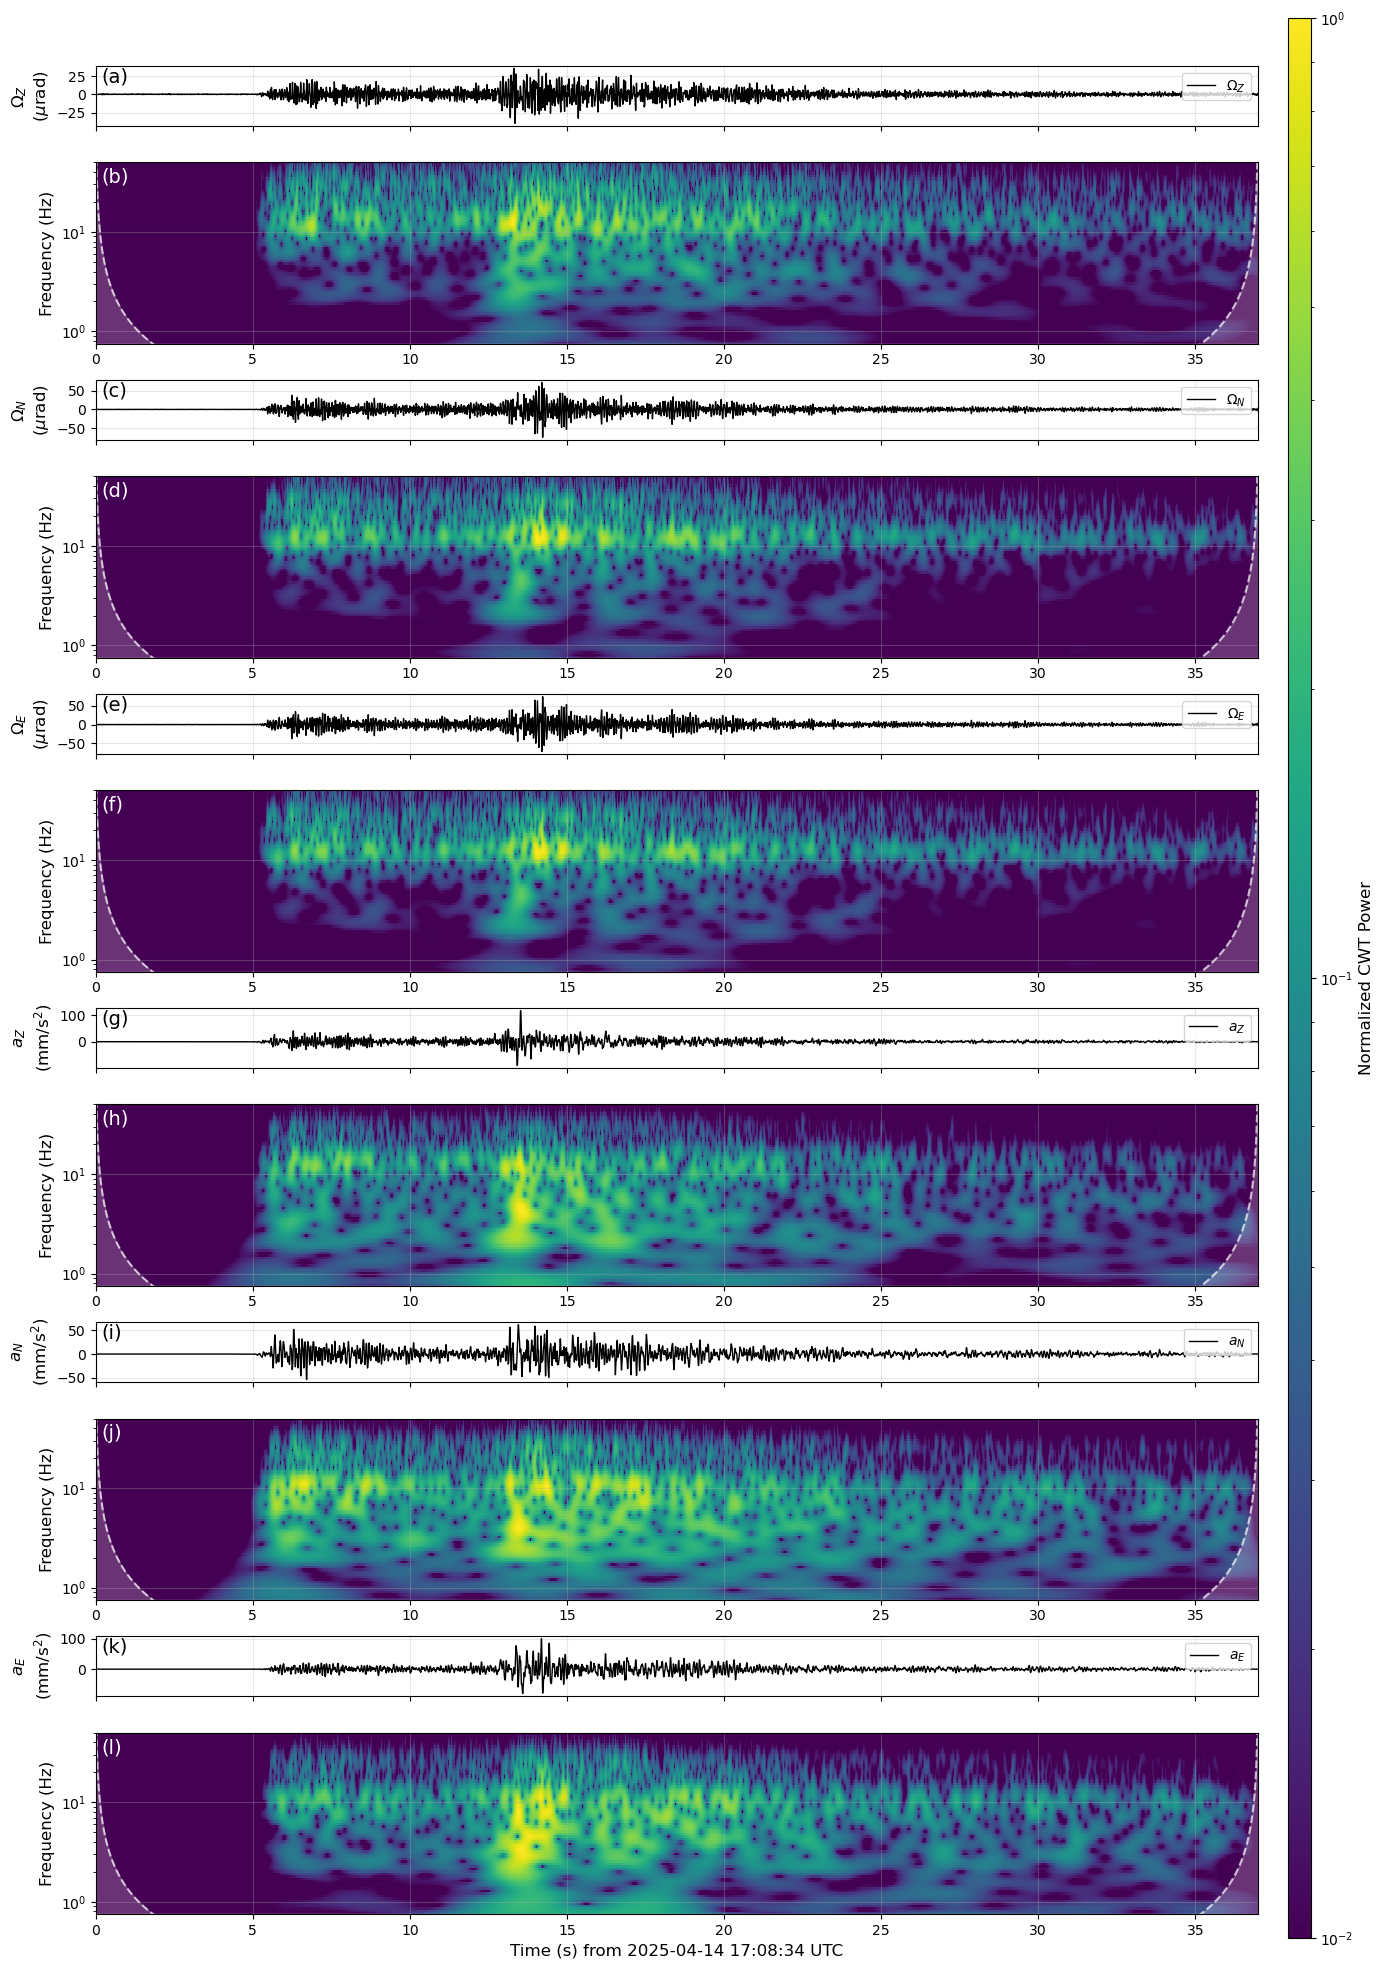

In [13]:
# First compute CWT for all components
cwt_results = {}
for comp in ['Z', 'N', 'E']:
    # Rotation components
    rot_data = sd.get_stream("rotation").select(channel=f"*{comp}")[0]
    cwt_results[f"{comp}_Rotation"] = sixdegrees.compute_cwt(
        rot_data.times(), rot_data.data, rot_data.stats.delta,
        normalize=True
    )
    
    # Translation components
    acc_data = sd.get_stream("translation").select(channel=f"*{comp}")[0]
    cwt_results[f"{comp}_Translation"] = sixdegrees.compute_cwt(
        acc_data.times(), acc_data.data, acc_data.stats.delta,
        normalize=True
    )

# Then plot all components
fig = sixdegrees.plot_cwt_all(
    rot=sd.get_stream("rotation"),
    acc=sd.get_stream("translation"),
    cwt_output=cwt_results,
    clog=True,
    ylim=50
)

Frequency band to filter (this is applied to the stream object after being reset to raw stream)

In [14]:
sd.filter_data(fmin=0.5, fmax=5.0, output=False)

Apply polarity correction if needed. This is applied to the stream object that is processed. If raw is True, the polarity correction is applied to the raw stream too.

In [15]:
sd.polarity_stream(pol_dict={"HZ": -1, "JZ": 1}, raw=False)

Let's compare the waveforms of the rotation (red) and translational (black) components. According to the theory both should be in phase for plane waves, thus the cross-correlation should be close to 1.

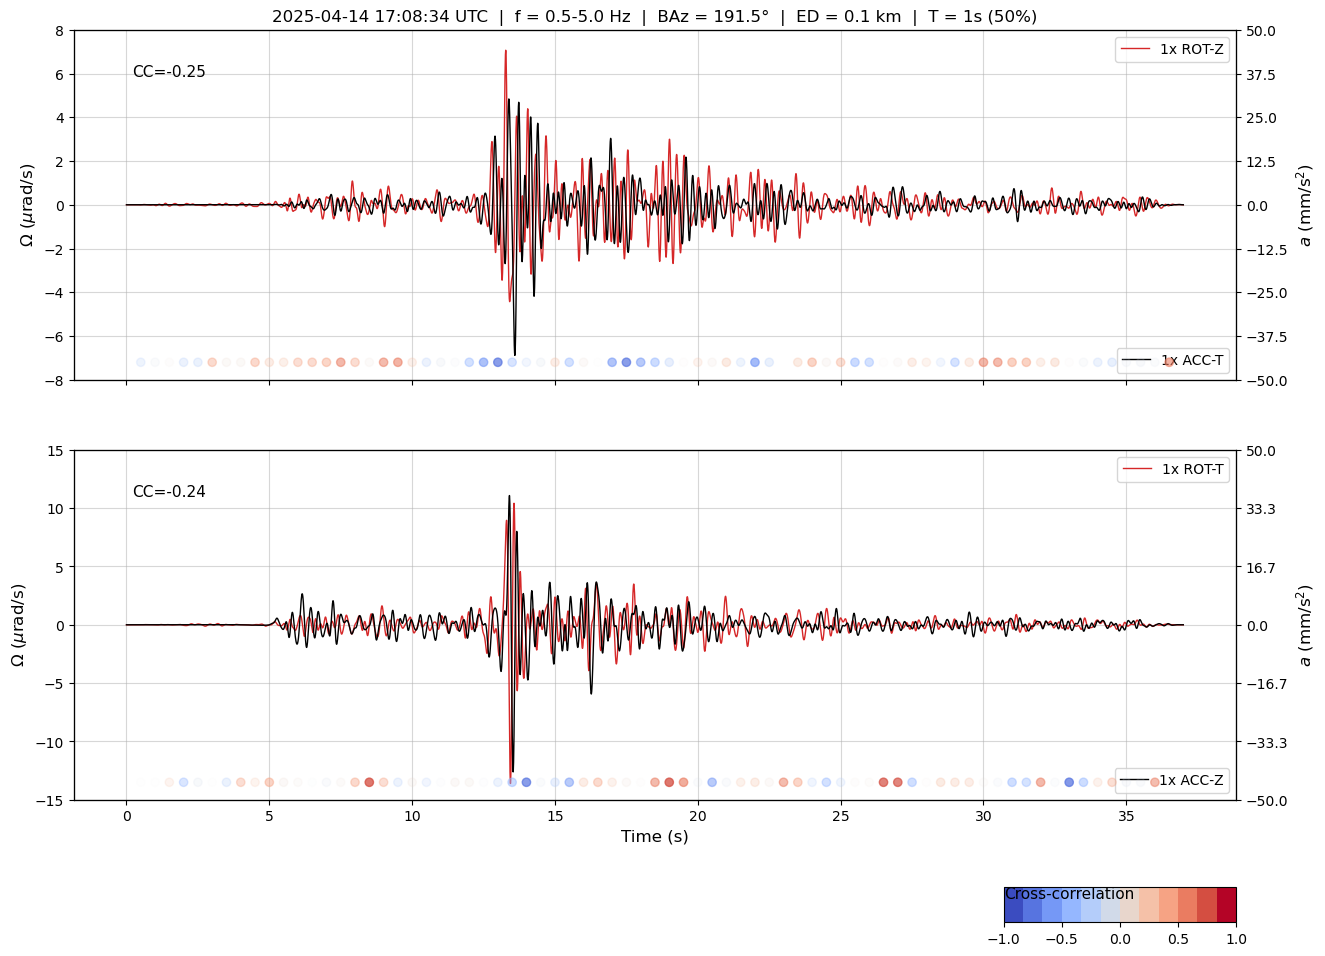

In [ ]:
fig = sd.plot_waveform_cc(rot0=sd.get_stream("rotation"),
                        acc0=sd.get_stream("translation"),
                        baz=ev['backazimuth'],
                        distance=ev['distance_km'],
                        fmin=sd.fmin, 
                        fmax=sd.fmax, 
                        twin_sec=1, 
                        twin_overlap=0.5,
                        )

In [17]:
sd.get_component_lag(normalize=True,
                     baz=ev['backazimuth'],
                     correct=True)

ROT-T & ACC-Z:  lag_time: 0.095 s, lag_samples: 19, cc_max: 0.75
ROT-Z & ACC-T:  lag_time: 0.09 s, lag_samples: 18, cc_max: 0.67


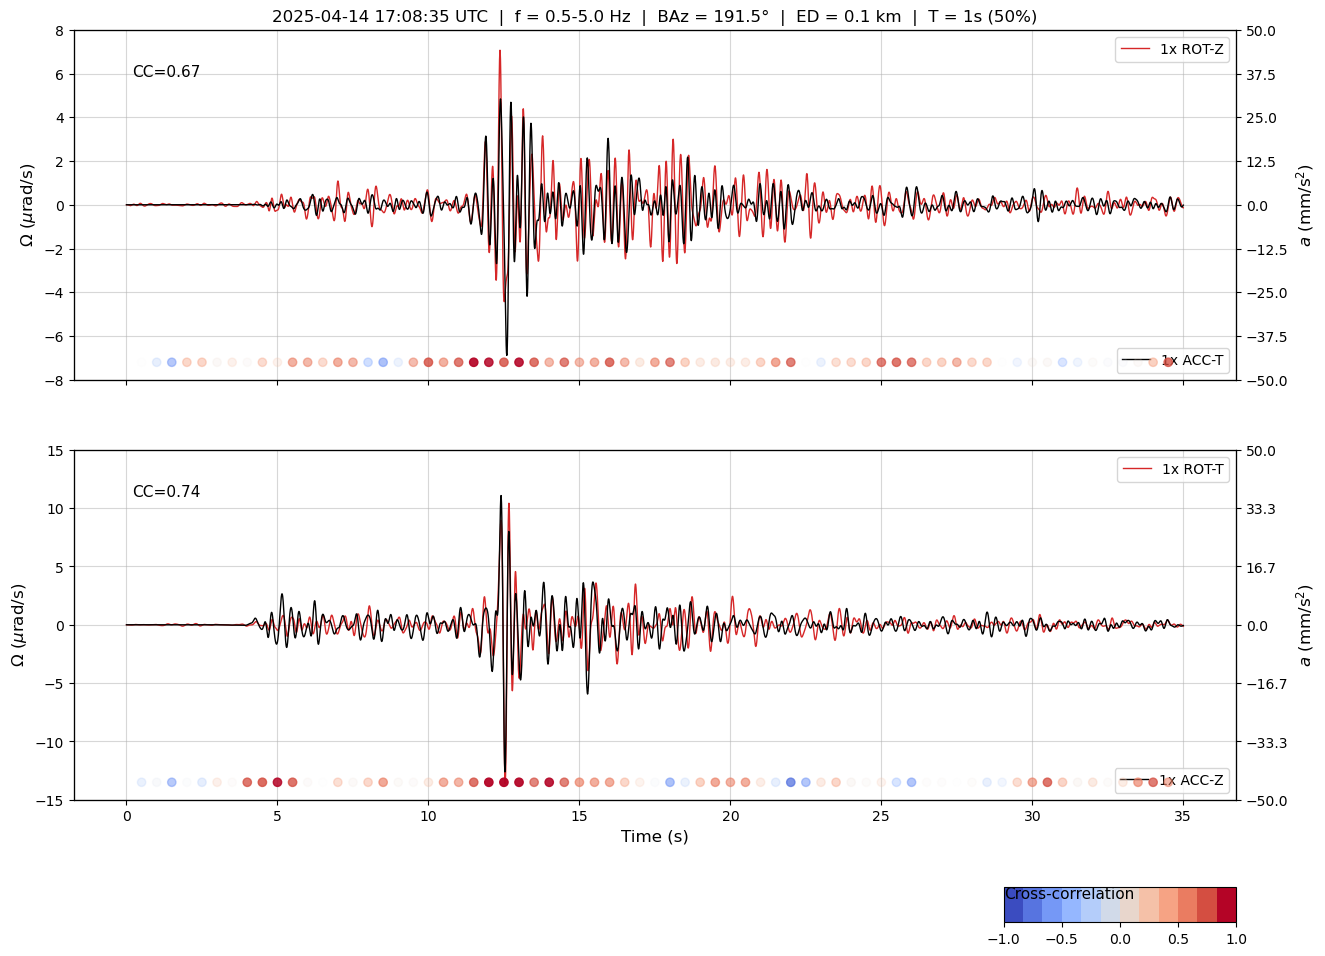

In [18]:
fig = sd.plot_waveform_cc(rot0=sd.get_stream("rotation"),
                        acc0=sd.get_stream("translation"),
                        baz=ev['backazimuth'],
                        distance=ev['distance_km'],
                        fmin=sd.fmin, 
                        fmax=sd.fmax, 
                        twin_sec=1, 
                        twin_overlap=0.5,
                        )

Here we can compare the FFT spetra of the rotation and translational components.

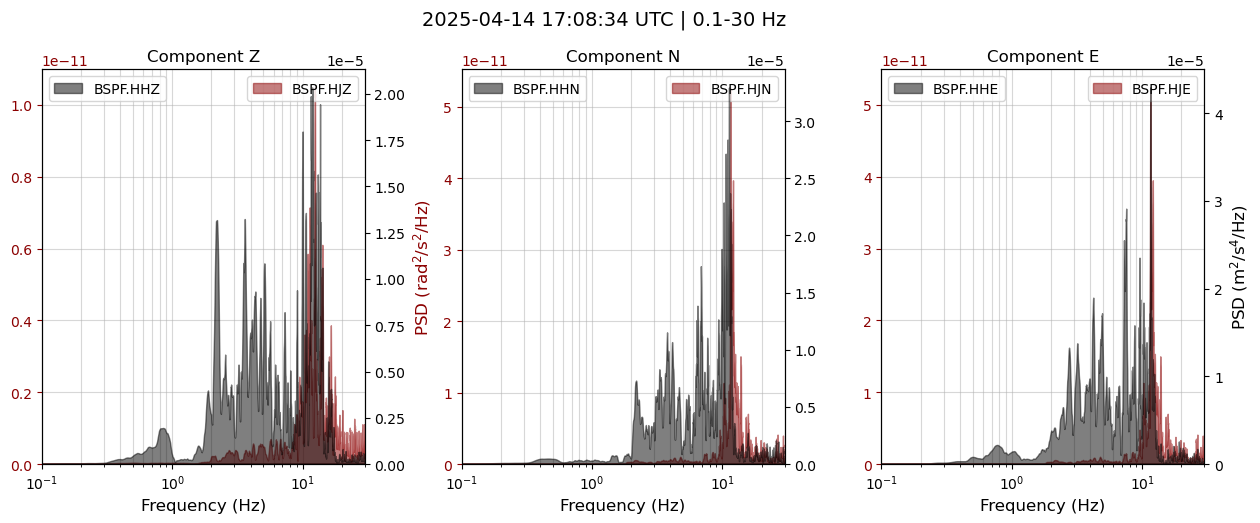

In [21]:
fig = sd.plot_spectra_comparison_fill(rot=sd.get_stream("rotation", raw=True), 
                                      acc=sd.get_stream("translation", raw=True),
                                      fmin=0.1, fmax=30,
                                      ylog=False, xlog=True, fill=True
                                      )

### Backazimuth Estimate

Now we want to estimate the backazimuth of the event. We can do this by computing the cross-correlation between the rotation and translational components (representing Love and Rayleigh waves, respectively) for different backazimuths.


using love waves for backazimuth estimation ...
max = 213, mean = 218.0, std = 20.92470396828203


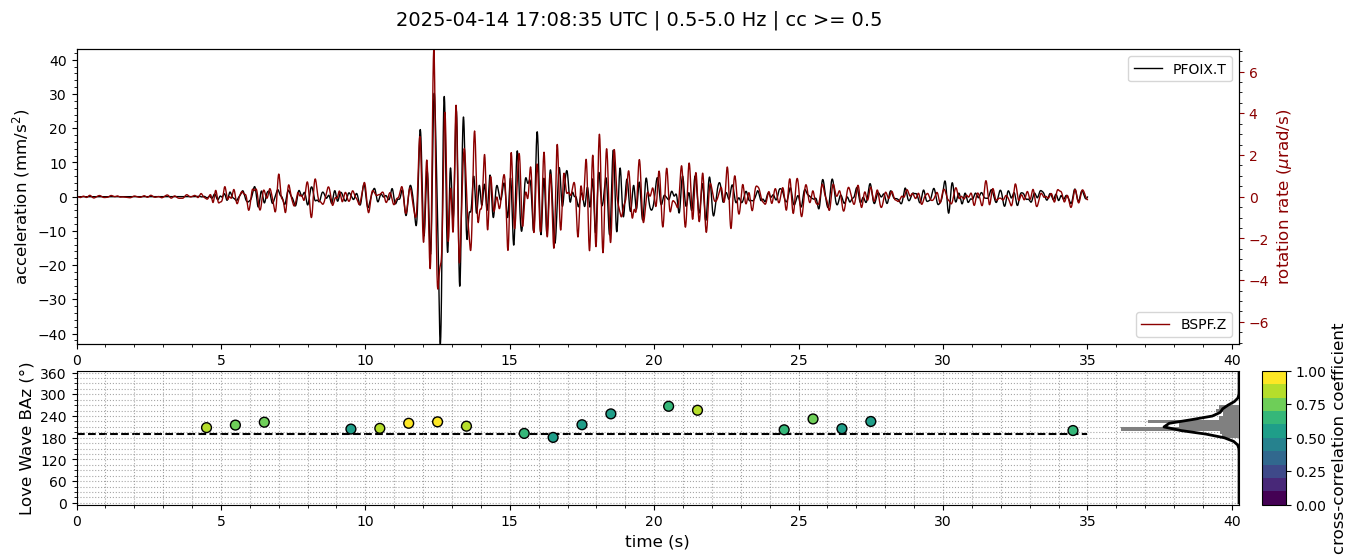

In [24]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='love',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_sec_overlap=config['twin_overlap'],
    out=True
)

# Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='love',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)


using rayleigh waves for backazimuth estimation ...
max = 132, mean = 180.0, std = 88.51583023996542


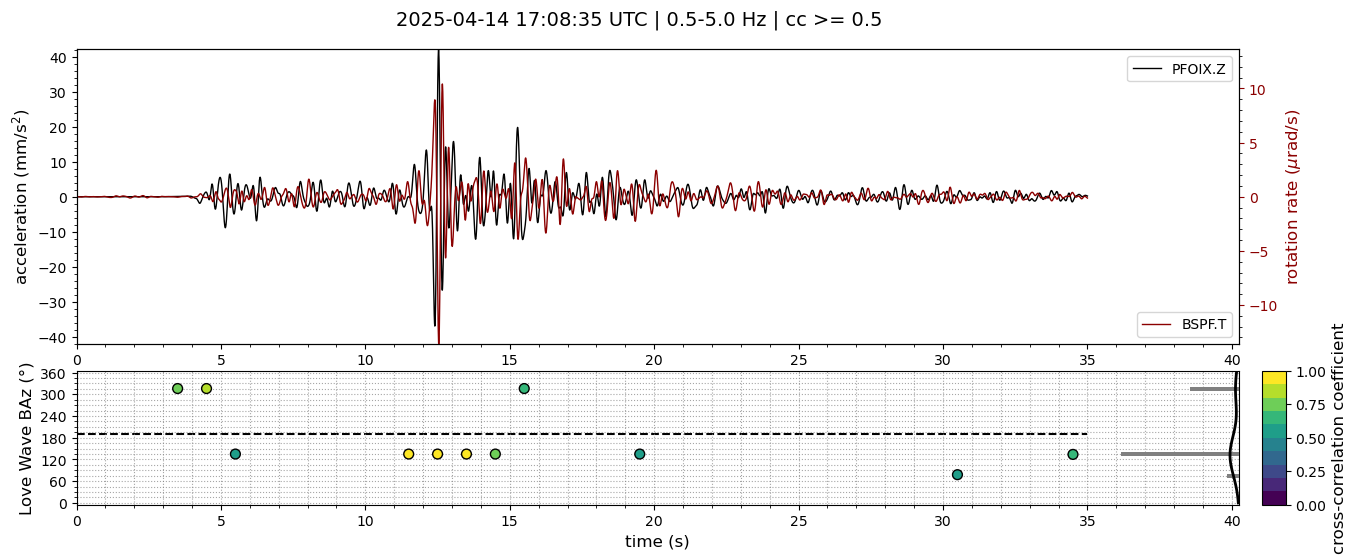

In [33]:
# First compute backazimuth
baz_results = sd.compute_backazimuth(
    wave_type='rayleigh',
    baz_step=config['baz_step'],
    baz_win_sec=config['twin_sec'],
    baz_win_sec_overlap=config['twin_overlap'],
    out=True
)

# # Then plot results
fig = sd.plot_backazimuth_results(
    baz_results,
    wave_type='rayleigh',
    baz_theo=ev['backazimuth'],
    cc_threshold=0.5,  # optional
)

We can also compare the different backazimuth estimation methods. This also includes a method based on the horizontal rotation components (called tangent method). This is then compared to the theoretical backazimuth (based on the event location).


using love waves for backazimuth estimation ...

Estimated BAZ Love = 213° (CC ≥ 0.5)

using rayleigh waves for backazimuth estimation ...

Estimated BAZ Rayleigh = 311° (CC ≥ 0.5)

using tangent for backazimuth estimation ...

Estimated BAZ Tangent = 225° (CC ≥ 0.5)


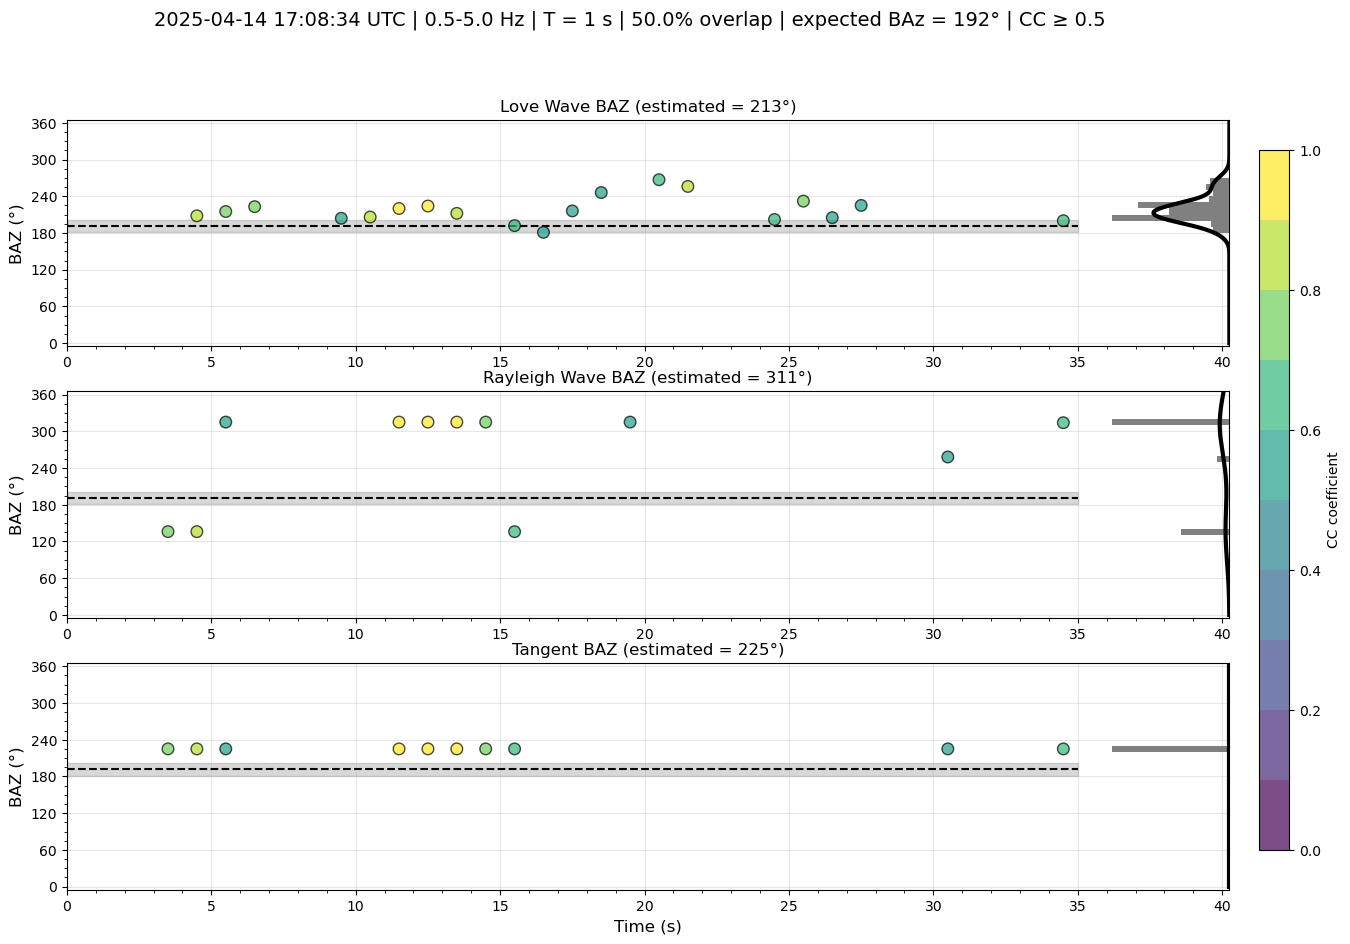

In [26]:
fig, results = sd.compare_backazimuth_methods(
    Twin=config['twin_sec'],
    Toverlap=config['twin_overlap'],
    invert_rot_z=False,
    invert_acc_z=False,
    cc_threshold=0.5,
    baz_theo=ev['backazimuth'],
    plot=True,
    output=True
)

### Analyse phase velocities

6 DoF observations allow us to estimate the phase velocities of Love and Rayleigh waves based on the amplitude ratios. For the estimation we use linear regression methods (ODR and RANSAC) to estimate the slope of rotational and translational amplitudes in time windows.


In [29]:
# Compute Love wave velocities
love_velocities = sd.compute_velocities(
    wave_type='love',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=0.75,
    method='odr',
    baz=ev['backazimuth']  # optional
)

# Compute Rayleigh wave velocities
rayleigh_velocities = sd.compute_velocities(
    wave_type='rayleigh',
    win_time_s=config['twin_sec'],
    overlap=config['twin_overlap'],
    cc_threshold=0.75,
    method='odr',
    baz=ev['backazimuth']  # optional
)

We can plot the results with the waveforms which are rotated using the theoretical backazimuth.

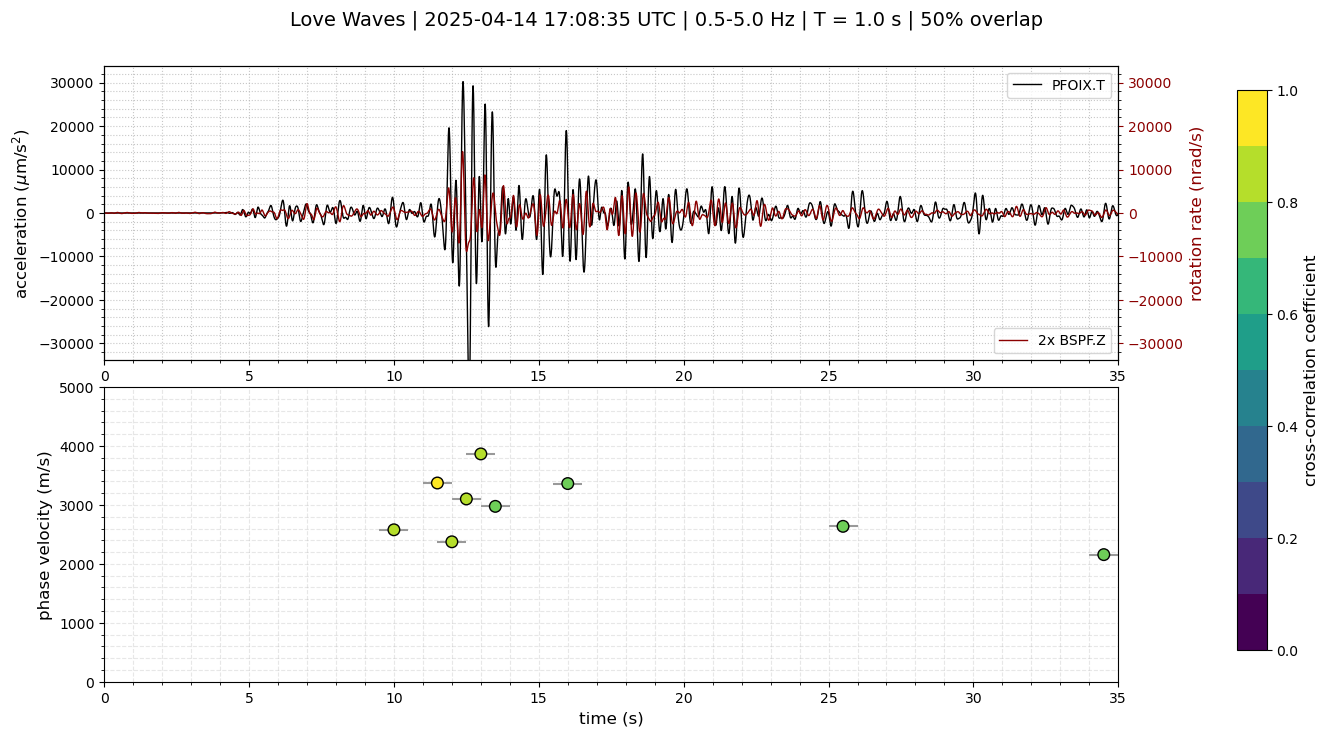

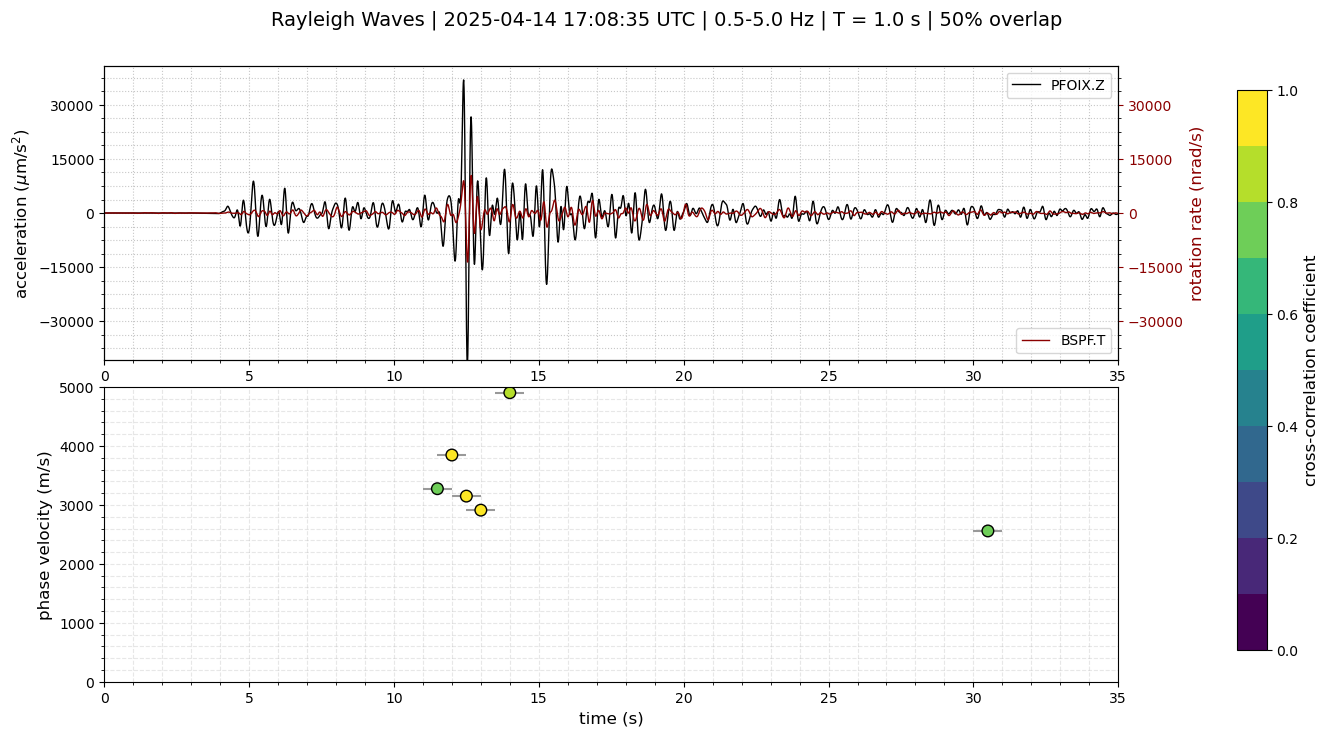

In [30]:
# Plot results
fig = sd.plot_velocities(
    velocity_results=love_velocities,
    vmax=5000,  # optional
    minors=True # optional
)

# Plot results
fig = sd.plot_velocities(
    velocity_results=rayleigh_velocities,
    vmax=5000,  # optional
    minors=True # optional
)